## 02 - Data Exploration

*Explore the dataset thoroughly, look for patterns, and find some muffens*

In [ ]:
from pathlib import Path
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
project_root = Path.cwd().parent

df = pd.read_csv(
    project_root / "data" / "processed" / "calls_cleaned.csv",
    parse_dates=['date_stamp'] #ensure datetime on load
)

display(df)

,date_stamp,time,day_of_week,month,year,dialled_phone_number,name,duration_in_seconds,category,hour,is_business_hours
0,2022-01-01,16:03:01,Saturday,January,2022,648578192,Abel,179,Unknown,16,False
1,2022-01-01,16:06:17,Saturday,January,2022,814500001,Husband CEL01,66,Family,16,False
2,2022-01-01,19:08:44,Saturday,January,2022,814500001,Husband CEL01,38,Family,19,False
3,2022-01-01,20:03:11,Saturday,January,2022,694500003,Daughter MAS01,1283,Family,20,False
4,2022-01-02,14:22:44,Sunday,January,2022,814500001,Husband CEL01,66,Family,14,False
...,...,...,...,...,...,...,...,...,...,...,...
24947,2024-10-04,19:33:03,Friday,October,2024,680900016,Daughter ANG01,22,Family,19,False
24948,2024-10-04,20:06:28,Friday,October,2024,826902002,Accountant - Tom,12,Important Contacts,20,False
24949,2024-10-04,20:06:50,Friday,October,2024,826902002,Accountant - Tom,4,Important Contacts,20,False
24950,2024-10-04,20:07:53,Friday,October,2024,826902002,Accountant - Tom,2,Important Contacts,20,False


### Call Duration

Let's take a closer look at the duration_in_seconds column

In [3]:
df['duration_in_seconds'].describe()

count    24952.000000
mean       103.140430
std        287.153126
min          1.000000
25%          9.000000
50%         34.000000
75%         84.000000
max       7200.000000
Name: duration_in_seconds, dtype: float64

Interesting. We have a right-skewed distribution, where the mean is 3 times larger than the median! Here we have some "muffens" as we say in norwegian (We sense some weird behaviour - what could these long calls be - making the mean so high?)

In [4]:
df['duration_in_seconds'].quantile([0.9, 0.95, 0.99, 1.0])

0.90     211.00
0.95     396.00
0.99    1273.98
1.00    7200.00
Name: duration_in_seconds, dtype: float64

This tells us 99% of calls are are under 21 minutes, while the remaining 1% are between 21m and 120m

In [5]:
df.groupby('category').agg(
      total_calls=('category', 'count'),
      pct_business_hours=('is_business_hours', 'mean'),
      avg_duration=('duration_in_seconds', 'median')
  ).sort_values('pct_business_hours', ascending=False)

,total_calls,pct_business_hours,avg_duration
category,,,
Supplier,2659,0.843174,42.0
Service Provider,303,0.838284,362.0
Unknown,11579,0.640815,29.0
Family,9827,0.506258,36.0
Important Contacts,584,0.385274,23.0


### Business Hours by Category

Interesting - Unknown is more business-like than Family:

- **Family:** 49% outside business hours
- **Unknown:** only 36% outside business hours

Let's see if call behavior differs during vs outside business hours

In [6]:
df.groupby(['category', 'is_business_hours']).agg(
      total_calls=('category', 'count'),
      avg_duration=('duration_in_seconds', 'median')
  ).unstack()

total_calls       avg_duration       
is_business_hours        False True         False  True 
category                                                
Family                    4852  4975         35.0   37.0
Important Contacts         359   225         23.0   27.0
Service Provider            49   254        272.0  377.5
Supplier                   417  2242         31.0   45.0
Unknown                   4159  7420         28.0   30.0

Call behavior is mostly the same during vs outside business hours. The main difference: Service Provider and Supplier calls are longer during work hours - probably because you actually get through to someone instead of leaving voicemails.

### Hourly Patterns

When does call traffic peak?

<Axes: title={'center': 'Calls by Hour of Day'}, xlabel='hour'>

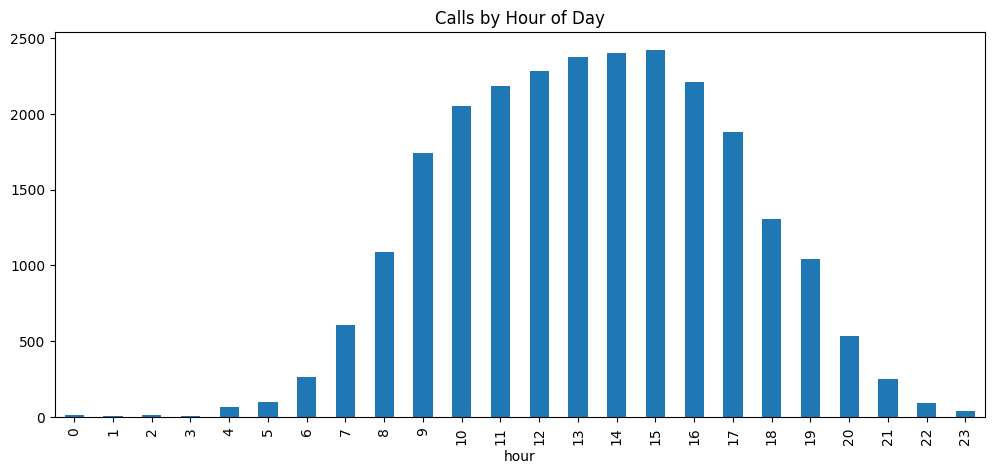

In [7]:
df['hour'].value_counts().sort_index().plot(kind = 'bar', figsize = (12,5), title = 'Calls by Hour of Day')

Classic business day pattern - ramps up from 7 AM, peaks around 2-4 PM, tapers off by 9 PM. Minimal late-night activity.

Do different categories peak at different times?

<Axes: title={'center': 'Hourly Distribution by Category (%)'}, xlabel='hour'>

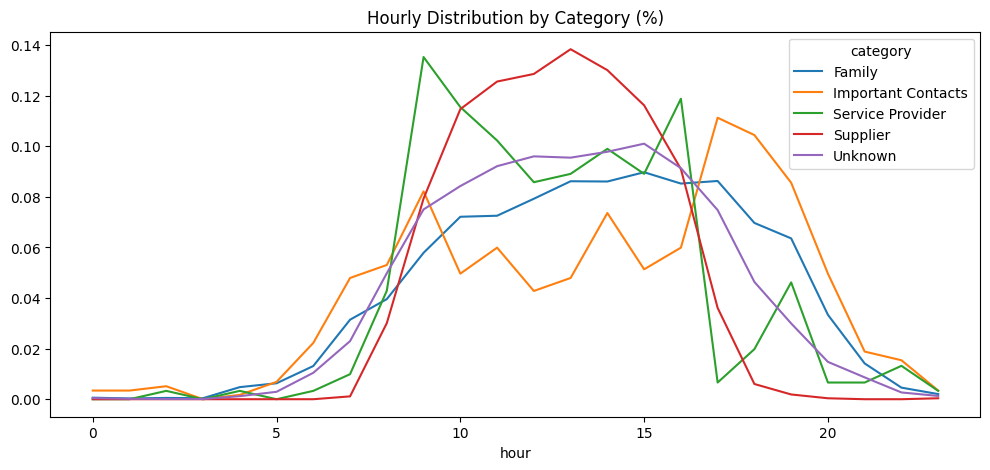

In [8]:
hourly_crosstab = pd.crosstab(df['hour'], df['category'], normalize='columns')
hourly_crosstab.plot(kind='line', figsize=(12,5), title='Hourly Distribution by Category (%)')

**Hourly patterns reveal distinct calling behaviors by category:**

- **Service Provider & Supplier** are tightly concentrated during business hours (8-17), with sharp drop-offs afterward. These are formal business relationships with limited availability windows.
- **Important Contacts** show a unique evening peak (18-19), suggesting operational contacts (drivers, tenants) who are reached after the workday.
- **Family** maintains activity into the evening (19-21), consistent with african families who stay connected.
- **Unknown** follows a hybrid pattern - more business-hours focused than Family, but not as sharply concentrated as Supplier/Service Provider. This suggests Unknown is heterogeneous - a mix of different types of contacts.

### Contact Analysis

Let's look at who's being called

In [9]:
calls_per_contact = df['name'].value_counts()
calls_per_contact.describe()

count    2091.000000
mean       11.933046
std        83.240973
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      2413.000000
Name: count, dtype: float64

75% of contacts are called 4 times or less, with a mean of 12 calls per contact. The most frequently dialed number has 2413 calls - that's roughly 2-3 calls per day over 3 years. Who could this be?

In [10]:
contact_summary = df.groupby('name').agg(
    total_calls=('name', 'count'),
    category=('category', 'first')
).sort_values('total_calls', ascending=False)

contact_summary.head(20)

,total_calls,category
name,,
Husband CEL01,2413,Family
Sister MAS01,1473,Family
Daughter ANG01,1272,Family
Daughter AYA02,1077,Family
Daughter AYA01,917,Family
Alli,905,Unknown
Daughter MAS01,756,Family
Candidate CEL01,477,Family
HK Computers,421,Supplier


Ah, it's the husband of course. This leads me to believe the caller is the wife - most calls are to family (husband, children, sister, mother, niece). A mother with a major role in their family business, perhaps.

On top of this expected family-heavy result, we spot some *muffens*. 5 Unknown contacts in the top 20:

| Name | Calls | Notes |
|------|-------|-------|
| Alli | 905 | Called almost daily, 66% business hours |
| Park | 287 | Very short calls (5s median), 73% business hours |
| Eric | 219 | Only 31% business hours - *suspicious* |
| Duma | 210 | Only 30% business hours - *suspicious* |
| Zohra | 203 | Started in 2023, 69% business hours |

Let's profile these 5 unknown callers

In [11]:
top_unknowns = ['Alli', 'Park', 'Eric', 'Duma', 'Zohra']
unknown_calls = df[df['name'].isin(top_unknowns)]

unknown_calls.groupby('name').agg(
      total_calls=('name', 'count'),
      avg_duration=('duration_in_seconds', 'median'),
      pct_business_hours=('is_business_hours', 'mean'),
      avg_hour=('hour', 'mean'),
      earliest_call=('date_stamp', 'min'),
      latest_call=('date_stamp', 'max')
  )


,total_calls,avg_duration,pct_business_hours,avg_hour,earliest_call,latest_call
name,,,,,,
Alli,905,22.0,0.659669,12.898343,2022-01-03,2024-09-28
Duma,210,24.5,0.304762,14.038095,2022-01-16,2022-11-03
Eric,219,27.0,0.310502,14.305936,2022-01-17,2024-08-01
Park,287,5.0,0.728223,13.393728,2022-02-28,2023-10-10
Zohra,203,40.0,0.689655,12.098522,2023-03-12,2024-07-09


Interesting mix. Alli, Park, and Zohra look business-like (66-73% during work hours). But **Duma** stands out - only 30% business hours means 70% of calls happen evenings and weekends. And **Eric** is similar at just 31%.

These 5 account for 15.8% of all Unknown calls (1,824 out of 11,579). Let's look for late-night activity

In [12]:
late_night = unknown_calls[(unknown_calls['hour'] >= 21) | (unknown_calls['hour'] < 6)]
late_night.groupby('name').agg(
      late_night_calls=('name', 'count'),
      avg_duration=('duration_in_seconds', 'mean'),
      max_duration=('duration_in_seconds', 'max')
  )

,late_night_calls,avg_duration,max_duration
name,,,
Duma,27,136.925926,1769
Eric,9,203.333333,1491


Eish. Only Duma and Eric have late-night calls:

**Duma:** 27 late night calls, averaging 2+ minutes, max of 30 minutes at 5 AM  
**Eric:** 9 late night calls, averaging 3+ minutes, max of 25 minutes

Taking into account that the caller is a married woman with children... these are some *concerning* findings. Let's see the details

In [13]:
late_night_details = late_night[['name', 'date_stamp', 'hour', 'duration_in_seconds', 'day_of_week']].sort_values(
      ['name', 'date_stamp']
  )

late_night_details

,name,date_stamp,hour,duration_in_seconds,day_of_week
1121,Duma,2022-02-16,4,123,Wednesday
1195,Duma,2022-02-17,4,13,Thursday
1196,Duma,2022-02-17,4,9,Thursday
1233,Duma,2022-02-18,4,4,Friday
1268,Duma,2022-02-18,21,5,Friday
1325,Duma,2022-02-20,21,10,Sunday
1326,Duma,2022-02-20,23,363,Sunday
1355,Duma,2022-02-22,4,52,Tuesday
1356,Duma,2022-02-22,4,3,Tuesday
1545,Duma,2022-02-28,4,5,Monday


**Duma** calls between 1-5 AM on weekdays. Multiple calls on single nights - some just seconds (checking if awake?), others several minutes. The 2022-04-05 sequence is wild: four calls at 4 AM, then a 30-minute call at 5 AM on a Tuesday.

**Eric** doesn't go past 11 PM, but that 25-minute call at 11 PM on a Friday (2024-07-12) is notable. Most calls are short, with occasional long ones.

Let's see the relationship timelines

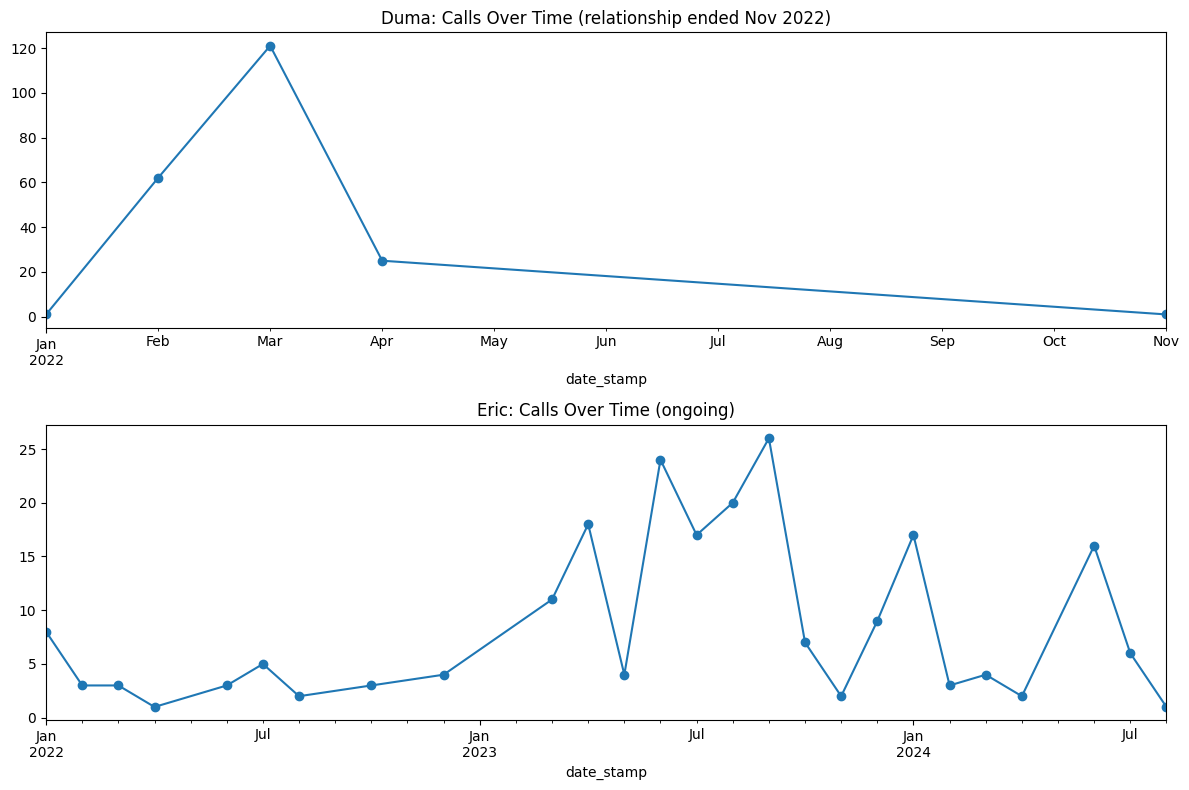

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

#duma timeline
duma_calls = df[df['name'] == 'Duma']
duma_monthly = duma_calls.groupby(duma_calls['date_stamp'].dt.to_period('M')).size()
duma_monthly.plot(kind='line', ax=axes[0], marker='o', title='Duma: Calls Over Time (relationship ended Nov 2022)')

#eric timeline
eric_calls = df[df['name'] == 'Eric']
eric_monthly = eric_calls.groupby(eric_calls['date_stamp'].dt.to_period('M')).size()
eric_monthly.plot(kind='line', ax=axes[1], marker='o', title='Eric: Calls Over Time (ongoing)')

plt.tight_layout()

Two very different stories:

**Duma:** Intense period in early 2022 - spiked to 120 calls in March, then sharp drop in April. Tapered off and ended by November 2022. Classic pattern of something that was discovered or ended under pressure.

**Eric:** Started slow in 2022, picked up through 2023-2024, still ongoing. A relationship that grew over time and continues today.

### Correlation Check

Could there be a "when husband's away" pattern? Let's compare call volumes

<Axes: title={'center': 'Monthly Calls: Husband vs Eric vs Duma'}, xlabel='date_stamp'>

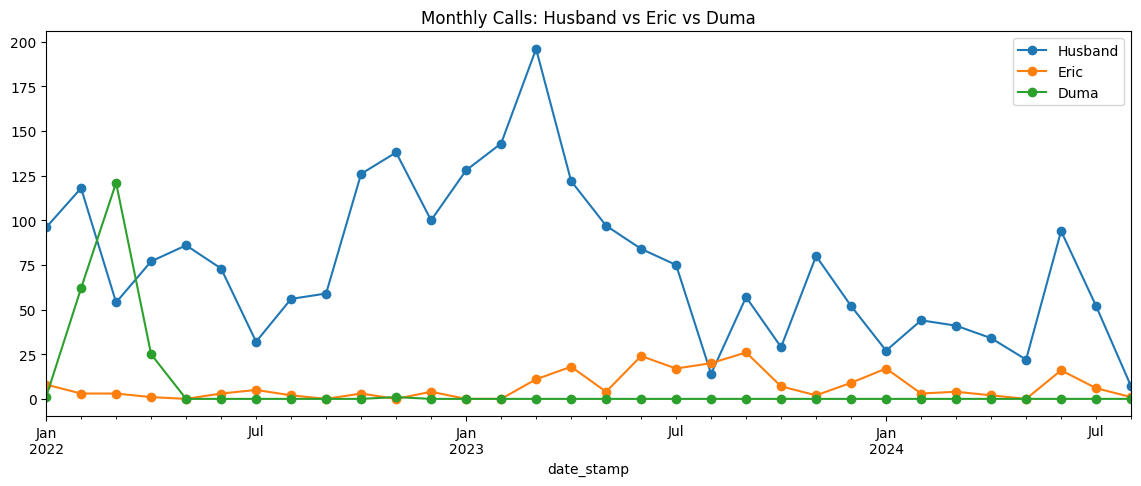

In [15]:
#monthly call volumes for husband, eric, duma
husband_monthly = df[df['name'] == 'Husband CEL01'].groupby(df['date_stamp'].dt.to_period('M')).size()
eric_monthly = df[df['name'] == 'Eric'].groupby(df['date_stamp'].dt.to_period('M')).size()
duma_monthly = df[df['name'] == 'Duma'].groupby(df['date_stamp'].dt.to_period('M')).size()

comparison = pd.DataFrame({
    'Husband': husband_monthly,
    'Eric': eric_monthly,
    'Duma': duma_monthly
}).fillna(0)

comparison.plot(kind='line', figsize=(14, 5), title='Monthly Calls: Husband vs Eric vs Duma', marker='o')

Hard to see patterns with the scale difference. Let's normalize and calculate actual correlations

In [16]:
#correlation matrix with styling
corr_matrix = comparison.corr()
corr_matrix.style.background_gradient(cmap='RdYlGn', vmin=-1, vmax=1).format('{:.3f}')

,Husband,Eric,Duma
Husband,1.000,-0.060,0.005
Eric,-0.060,1.000,-0.152
Duma,0.005,-0.152,1.000


All correlations near zero. No "when husband's away" pattern in the data.

The suspicious findings about Duma and Eric (4 AM calls, 25-minute late-night conversations) stand on their own merit - we just can't link them to husband's call patterns.

---

## Summary

### The Data
- **24,952 calls** over ~3 years (Jan 2022 - Oct 2024)
- **2,091 unique contacts** - but highly concentrated (top 20 contacts dominate)
- **Call duration:** Right-skewed, median 34s, mean 103s (the 1% of calls over 21 min pull up the average)

### Category Insights
| Category | % of Calls | Business Hours | Typical Duration |
|----------|------------|----------------|------------------|
| Unknown | 46% | 64% | 29s |
| Family | 39% | 51% | 36s |
| Supplier | 11% | 84% | 42s |
| Important Contacts | 2% | 39% | 23s |
| Service Provider | 1% | 84% | 362s |

**Unknown behaves more like business than personal** - 64% during work hours vs Family's 51%. This suggests Unknown contains hidden business contacts, not just personal calls.

### The Muffens

Two Unknown contacts show suspicious patterns:

**Duma**
- Only 30% of calls during business hours - 70% evenings/weekends
- 27 calls between 1-5 AM on weekdays
- 30-minute call at 5 AM on a Tuesday
- Intense period Feb-Mar 2022 (120 calls/month), then abrupt decline
- Contact ended November 2022

**Eric**  
- Only 31% of calls during business hours - 69% evenings/weekends
- 9 late-night calls (9-11 PM)
- 25-minute call at 11 PM on a Friday (July 2024)
- Contact has grown over time and is still ongoing

No inverse correlation found with Husband's call patterns - the suspicious timing stands on its own.

### For the doubters

The data tells a story, but not the whole story. Phone logs show *when* and *how long*, not *what was said*. Duma's pattern could be explained by timezone differences with an overseas contact. Eric's evening calls could be a friend.

But 4 AM calls on weekdays? That's harder to explain away. 